In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.debugger import set_trace
import math

# Cog Sci 132: Final Assignment

**Instructions:** Calculate an extracellular action potential that would be recorded by an extracellular probe at distances of 1,5 and 20 microns from the neuron. 

Assume that the action potential is generated at the axon initial segment (AIS), and make reasonable assumptions about the distribution of Na and K channels in the cell body and AIS.  

Make two different models of the types of current sources. One of these models should be a monopole. Create python code for the current sources and for the extracelular potential. 

Plot the extracellular potential below the action potential and compare the two. Compare with the results of the BUZSÁKI paper discussed in class.

## Group Members:
Haya Halabieh, *INSERT NAMES*

In [2]:
def check_type(y,t): # Ensure Input is Correct
    return y.dtype == np.floating and t.dtype == np.floating

class _Integrator():
    
    def integrate(self,func,y0,t):
        time_delta_grid = t[1:] - t[:-1]
        
        y = np.zeros((y0.shape[0],t.shape[0]))
        y[:,0] = y0
        
        # Euler Step or Runge-Kutta Second Order Integration Step
        for i in range(time_delta_grid.shape[0]):
            y[:,i+1] = time_delta_grid[i]*func(y[:,i],t[i])+y[:,i] # Euler Integration Step
            
            #Un-Comment the next three lines to use the Runge-Kutta Second Order Integration
            #k1=(1/2)*time_delta_grid[i]*func(y[:,i],t[i])
            #breakpoint()
            #y[:,i+1] = y[:,i]+time_delta_grid[i]*func(y[:,i]+k1,t[i]+time_delta_grid[i]/2)
            
        return y
       
        #Runge-Kutta Fourth Order Integration Step
        #for i in range(time_delta_grid.shape[0]):
            #k1 = func(y[:,i], t[i])# RK4 Integration Steps replace Euler's Updation Steps
            #half_step = t[i] + time_delta_grid[i] / 2
            #k2 = func(y[:,i] + time_delta_grid[i] * k1 / 2, half_step)
            #k3 = func(y[:,i] + time_delta_grid[i] * k2 / 2, half_step)
            #k4 = func(y[:,i] + time_delta_grid[i] * k3, t + time_delta_grid[i])
            #y[:,i+1]= (k1 + 2 * k2 + 2 * k3 + k4) * (time_delta_grid[i] / 6) + y[:,i]
        #return y


def odeint_rk4(func,y0,t):
    y0 = np.array(y0)
    t = np.array(t)
    if check_type(y0,t):
        return _Integrator().integrate(func,y0,t)
    else:
        print("error encountered")

In [3]:
C_m = 1      # Membrane Capacitance

g_K = 10
E_K = -95

g_Na = 100
E_Na = 50 

g_L = 0.15
E_L = -55

In [4]:
def f(x):
    
    if abs(x)<1e-12: 
        x=1
    elif x < -20:
        ex = np.exp(x)
        x = -x*ex/(1-ex)
    else: 
        x = x/(1-np.exp(-x))
    return x

def g(x):
    x = x/(np.exp(x)-1)
    return x

def h(x):
    if x < -20:
        x = np.exp(x)/(np.exp(x)+1)
    else: x = 1/(1+np.exp(-x))
    return x

def K_prop(v):

#αn(V ) = 0.032(V + 52)/(1 − exp(−(V + 52)/5))
    def alpha_n(v):
        u= (v+52)/5
        return 0.032*5*f(u)
    beta_n=0.5*np.exp(-(v+65)/80)

    def n_inf(v):
        return (alpha_n(v)/(alpha_n(v)+ beta_n))
        #set_trace()
    def tau_n(v):
        return (1/(alpha_n(v)+beta_n))
    #set_trace()
    return n_inf(v), tau_n(v)


def Na_prop(v):
    
#αm(V) = 0.32(V + 54)/(1 − exp(−(V + 54)/4))
#βm (V ) = 0.28(V + 27)/(exp((V + 27)/5) − 1)

    def alpha_m(v):
        u = (v+54)/4
        return 4*0.32*f(u)
    
    def beta_m(v):
        u =(v+27)/5
        return 5*0.28*g(u)

    def m_inf(v):
        return (alpha_m(v)/(alpha_m(v)+beta_m(v)))
    
    def tau_m(v):
        return (1 / (alpha_m(v) + beta_m(v)))

#αh(V) = 0.128 exp(−(V + 50)/18)
#βh(V) = 4/(1 + exp(−(V + 27)/5)

    alpha_h = 0.128*np.exp(-(v+50)/18)
                                 
    def beta_h(v):
        u = (v+27)/5
        return 4*h(u)
    
    def h_inf(v):
        return (alpha_h/(alpha_h+beta_h(v)))
    
    def tau_h(v):
        return 1/(alpha_h+beta_h(v))
    #set_trace()
    
    return m_inf(v), tau_m(v), h_inf(v), tau_h(v)


In [5]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_L(V):
    return g_L * (V - E_L)

In [6]:
def gPot(n):
    return g_K * n**4

def gSod():
    return 

In [7]:
def run_HH(v_clamp):
    
    def dXdt(X,t):
        V = v_clamp
        #V = X[0:1]
        m = X[0:1]
        h = X[1:2]
        n = X[2:3]

        #dVdt = (5 - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
        # Here the current injection I_injected = 5 uA
        
        
        
        n0,tn = K_prop(V)
        #set_trace()
        m0,tm,h0,th = Na_prop(V)
        
        dmdt = - (1.0/tm)*(m-m0)
        dhdt = - (1.0/th)*(h-h0)
        dndt = - (1.0/tn)*(n-n0)

        out = np.concatenate([dmdt,dhdt,dndt],0)
        return out

    V=v_clamp
    epsilon = 0.01
    t = np.arange(0, 3, epsilon)
    y0 = np.float64([0,1,0])
    
    state = odeint_rk4(dXdt, y0, t)
    

    #V = state[3]
    m = state[0]
    h = state[1]
    n = state[2]
    
    i_na = I_Na(V, m, h)
    i_k = I_K(V, n)
    i_l = I_L(V)
    i_m = i_na + i_k + i_l
    
    fig, ax = plt.subplots(1)
    ax.set_title("Voltage Clamp = " + str(v_clamp) + "V")
    ax.set_xlabel("Time")
    ax.plot(t, m**3, label = "m^3")
    ax.plot(t, h, label = "h")
    ax.plot(t, m**3*h, label= "m^3h")
    ax.legend()
    
    return

calculations:
sigma = 290 ohm cm
current = uA
voltage = mV
r = um



Monopole Approximation Equation: $$V_{x}(r) = \frac {i_{x}}{4*\pi*\sigma*r} $$

where r = distance (in Microns) and x = ion (e.g. Na/Sodium or K/Potassium)

$\sigma = 290 \Omega$

## Plotting Na and K Distance = 1 Micron

In [16]:
def dXdt(X,t):
        #V = v_clamp
        V = X[3:4] 
        m = X[0:1]
        h = X[1:2]
        n = X[2:3]
        
        omega = 200
        sin_voltage = 2*np.sin(omega*t)
        
        #1 ms -> 1 cycle
        #1000 
        
        
    
        dVdt = (5  - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / C_m 
        # Here the current injection I_injected = 5 uA
        
        
        
        n0,tn = K_prop(V)
        #set_trace()
        m0,tm,h0,th = Na_prop(V)
        
        dmdt = - (1.0/tm)*(m-m0)
        dhdt = - (1.0/th)*(h-h0)
        dndt = - (1.0/tn)*(n-n0)

        out = np.concatenate([dmdt,dhdt,dndt,dVdt],0)
        return out


epsilon = 0.01
t = np.arange(0, 5, epsilon) 

y0 = np.float64([0,1,0,-70])
    
state = odeint_rk4(dXdt, y0, t)

V = state[3]
m = state[0]
h = state[1]
n = state[2]

i_na = (I_Na(V, m, h))
V_na = i_na/ (4 * np.pi * 290 * (1- 0.2025))
i_k = (I_K(V, n))
V_k = i_k/ (4 * np.pi * 290 * (1- 0.2025))

voltage_1 = V_na + V_k




fig, ax = plt.subplots(1)
ax.set_title("Extracellular Voltage For Probe Distance 1 microns")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, voltage_, label = "Voltage")
#ax.plot(t, V_k, label = "V_k")
ax.legend()

#fig, ax = plt.subplots(1)
#ax.set_title("Voltage Clamp = "  + "V")
#ax.set_xlabel("Time")
#ax.plot(t, m**3, label = "m^3")
#ax.plot(t, h, label = "h")
#ax.plot(t, m**3*h, label= "m^3h")
#ax.legend()
    

<ipython-input-2-32361678793f>:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  return y.dtype == np.floating and t.dtype == np.floating


TypeError: 'numpy.ndarray' object is not callable

## Plotting Na and K Distance = 5 Microns

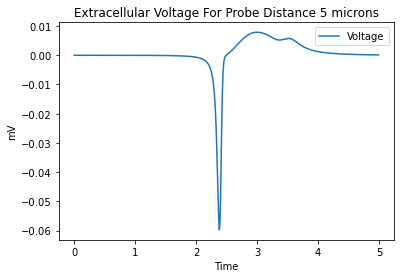

In [13]:
i_na = (I_Na(V, m, h))
V_na = i_na/ (4 * np.pi * 290 * (5- 0.2025))
i_k = (I_K(V, n))
V_k = i_k/ (4 * np.pi * 290 * (5- 0.2025))

voltage_5 = V_na + V_k




fig, ax = plt.subplots(1)
ax.set_title("Extracellular Voltage For Probe Distance 5 microns")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, voltage_5, label = "Voltage")
#ax.plot(t, V_k, label = "V_k")
ax.legend()

#V_na = i_na/ (4 * np.pi * 20 * 5)
#V_k = i_k/ (4 * np.pi * 20 * 5)

#fig, ax = plt.subplots(1)
#ax.set_xlabel("Time")
#ax.plot(t, V_na, label = "V_na")
#ax.plot(t, V_k, label = "V_k")
#ax.legend()

#fig, ax = plt.subplots(1)
#ax.set_title("Voltage Clamp = "  + "V")
#ax.set_xlabel("Time")
#ax.plot(t, m**3, label = "m^3")
#ax.plot(t, h, label = "h")
#ax.plot(t, m**3*h, label= "m^3h")
#ax.legend()
    

## Plotting Na and K Distance = 20 Microns

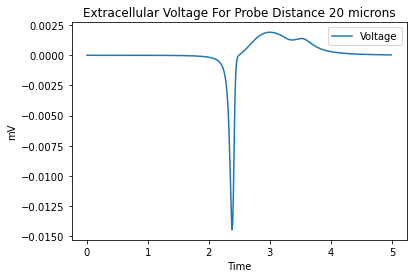

In [10]:
i_na = (I_Na(V, m, h))
V_na = i_na/ (4 * np.pi * 290 * (20- 0.2025))
i_k = (I_K(V, n))
V_k = i_k/ (4 * np.pi * 290 * (20- 0.2025))

voltage_20 = V_na + V_k




fig, ax = plt.subplots(1)
ax.set_title("Extracellular Voltage For Probe Distance 20 microns")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, voltage_20, label = "Voltage")
#ax.plot(t, V_k, label = "V_k")
ax.legend()


#V_na = i_na/ (4 * np.pi * 20 * 20)
#V_k = i_k/ (4 * np.pi * 20 * 20)

#fig, ax = plt.subplots(1)
#ax.set_xlabel("Time")
#ax.plot(t, V_na, label = "V_na")
#ax.plot(t, V_k, label = "V_k")
#ax.legend()

#fig, ax = plt.subplots(1)
#ax.set_title("Voltage Clamp = "  + "V")
#ax.set_xlabel("Time")
#ax.plot(t, m**3, label = "m^3")
#ax.plot(t, h, label = "h")
#ax.plot(t, m**3*h, label= "m^3h")
#ax.legend()
    

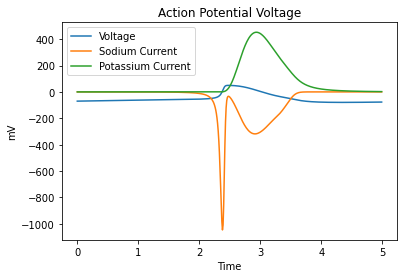

In [20]:
fig, ax = plt.subplots(1)
ax.set_title("Action Potential Voltage")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, V, label = "Voltage")
ax.plot(t, i_na, label= "Sodium Current")
ax.plot(t, i_k, label= "Potassium Current")
ax.legend()

Because we are measuring voltage with respect to time, we overlay the temporal measurements of electrical potential for the action potential itself, as well as $I_{na}$ and $I_k$ to get the graph above. This graph aligns with what we would expect, as determined by the readings, because voltage is linear, as such the electrical potentials can be superimposed (as done in the graph above) $$\phi_e = \sum_i \frac{I_i}{4\pi \sigma r}$$

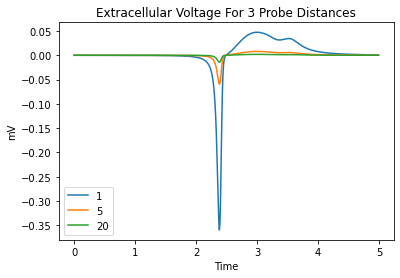

In [12]:
fig, ax = plt.subplots(1)
ax.set_title("Extracellular Voltage For 3 Probe Distances")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, voltage_1, label = "1")
ax.plot(t, voltage_5, label = "5")
ax.plot(t, voltage_20, label= "20")
ax.legend()

Note that the action potential has an inverse relationship (graphically) to the extracellular potential as observed in the above graphs. 

# Choosing an Alternative Model

Below are the options of alternative models to the monopole model (already explored above).

## Synaptic Model

From Kopell et. al., "We adopt the synaptic model of Ermentrout and Kopell (1998). Each synapse is characterized by a synaptic gating variable s associated with the presynaptic neuron, with $0 ≤ s ≤ 1$. This variable obeys:

$$\frac{ds}{dt} = \rho(V) \frac{1-s}{\tau_R} - \frac{s}{\tau_D}$$

where $\rho$ denotes a smoothed Heaviside function
$$\rho(V) = \frac{1+\tanh(\frac V 4)}{2}$$


## Electrical Potential of a Continuous Charge Distribution


$$ V = \frac{1}{4\pi\sigma} \int \frac{dq}{r} = \frac{1}{4 \pi \sigma} \int_V \frac{\rho(r) d\tau}{r} $$

where $\rho(r)$ is the charge distribution over the differential volume component, $d\tau$

[Source linked here.](https://www2.tntech.edu/leap/murdock/books/v4chap4.pdf)

## Area Charge Density vs. Linear Charge Density

Area Charge Density: $$\sigma dA = dQ$$
Linear Charge Density: $$\lambda dx = dQ$$

Substituting the *linear charge density* for the area charge density, used in the equation above, we can model the electrical potential as a neuron with linear charge density (i.e. an infinite line) rather than a cylinder.

$$ V = \frac{I_x}{2 \pi \sigma} * \ln(r) $$

[Source linked here.](https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_Introductory_Physics_-_Building_Models_to_Describe_Our_World_(Martin_Neary_Rinaldo_and_Woodman)/18%3A_Electric_potential/18.03%3A_Calculating_electric_potential_from_charge_distributions)

Using the natural log can transform a quadratic variable to a linear variable. 

In [38]:
def linear_potential(radius, volt):
    lam = volt
    sigma=290
    denom = 2 * np.pi * sigma
    ln = math.log2(radius)
    return (lam/denom) * ln


### Radius = 1 Micron

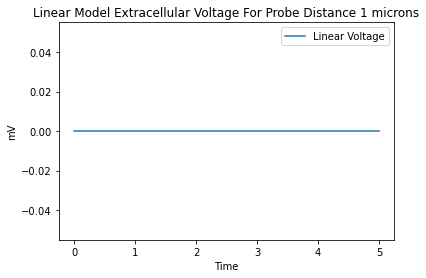

In [40]:
l_i_na = (I_Na(V, m, h))
l_V_na = linear_potential(radius=1, volt=l_i_na)
l_i_k = (I_K(V, n))
l_V_k = linear_potential(radius=1, volt=l_i_k)

linear_voltage_1 = l_V_na + l_V_k




fig, ax = plt.subplots(1)
ax.set_title("Linear Model Extracellular Voltage For Probe Distance 1 microns")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, linear_voltage_1, label = "Linear Voltage")
#ax.plot(t, V_k, label = "V_k")
ax.legend()

### Radius = 5 Microns

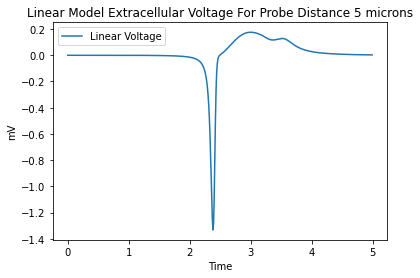

In [45]:
l_i_na = (I_Na(V, m, h))
l_V_na = linear_potential(radius=5, volt=l_i_na)
l_i_k = (I_K(V, n))
l_V_k = linear_potential(radius=5, volt=l_i_k)

linear_voltage_5 = l_V_na + l_V_k




fig, ax = plt.subplots(1)
ax.set_title("Linear Model Extracellular Voltage For Probe Distance 5 microns")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, linear_voltage_5, label = "Linear Voltage")
#ax.plot(t, V_k, label = "V_k")
ax.legend()

### Radius = 20 Microns

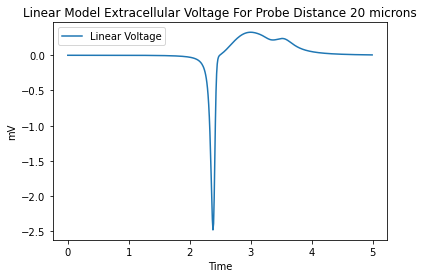

In [46]:
l_i_na = (I_Na(V, m, h))
l_V_na = linear_potential(radius=20, volt=l_i_na)
l_i_k = (I_K(V, n))
l_V_k = linear_potential(radius=20, volt=l_i_k)

linear_voltage_20 = l_V_na + l_V_k




fig, ax = plt.subplots(1)
ax.set_title("Linear Model Extracellular Voltage For Probe Distance 20 microns")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, linear_voltage_20, label = "Linear Voltage")
#ax.plot(t, V_k, label = "V_k")
ax.legend()

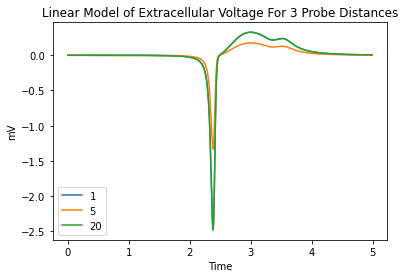

In [48]:
fig, ax = plt.subplots(1)
ax.set_title("Linear Model of Extracellular Voltage For 3 Probe Distances")
ax.set_xlabel("Time")
ax.set_ylabel("mV")
ax.plot(t, linear_voltage_1, label = "1")
ax.plot(t, linear_voltage_5, label = "5")
ax.plot(t, linear_voltage_20, label= "20")
ax.legend()

Note that the plot for the linear voltage model of radius 1 is a horizontal line, with slope = 0, because the voltage equation depends on the natural log of the radius difference (between a point charge and infinite line) so taking the natural log of 1 gives 0 and thus a flat line for radius = 1. Otherwise, the models for radius 5 and 20 are more similar to the monopole model of extracellular potential. 

## Research Background

#### Paper: "Intracellular Features Predicted by Extracellular Recordings in the Hippocampus In Vivo"

**Key Results**: 
- For the 11 somatic intracellular recordings obtained for this study, the average extracellular spike started 0.01 6 0.02 (SD) ms and ended 0.02 6 0.14 ms earlier than the corresponding points on the average intracellular action potential. 
- The action potential duration was calculated to be 1.28 6 0.18 ms and 1.27 6 0.19 ms from the intracellular and extracellular waveforms, respectively. As expected, there was a linear relationship between the intracellular and extracellular spike durations across individual cells (R 5 0.66, P , 0.03). Thus the duration of the intracellular action potential (from onset to return to baseline; tr 1 td in Fig. 1C) is well approximated by the time elapsed between the onset and the late positive peak of the extracellularly recorded waveform. 
- The negative peak of the extracellular spike preceded the peak of the intracellular somatic action potential by 0.20 6 0.08 ms (ordinate values for black squaresin Fig. 3, B and C).
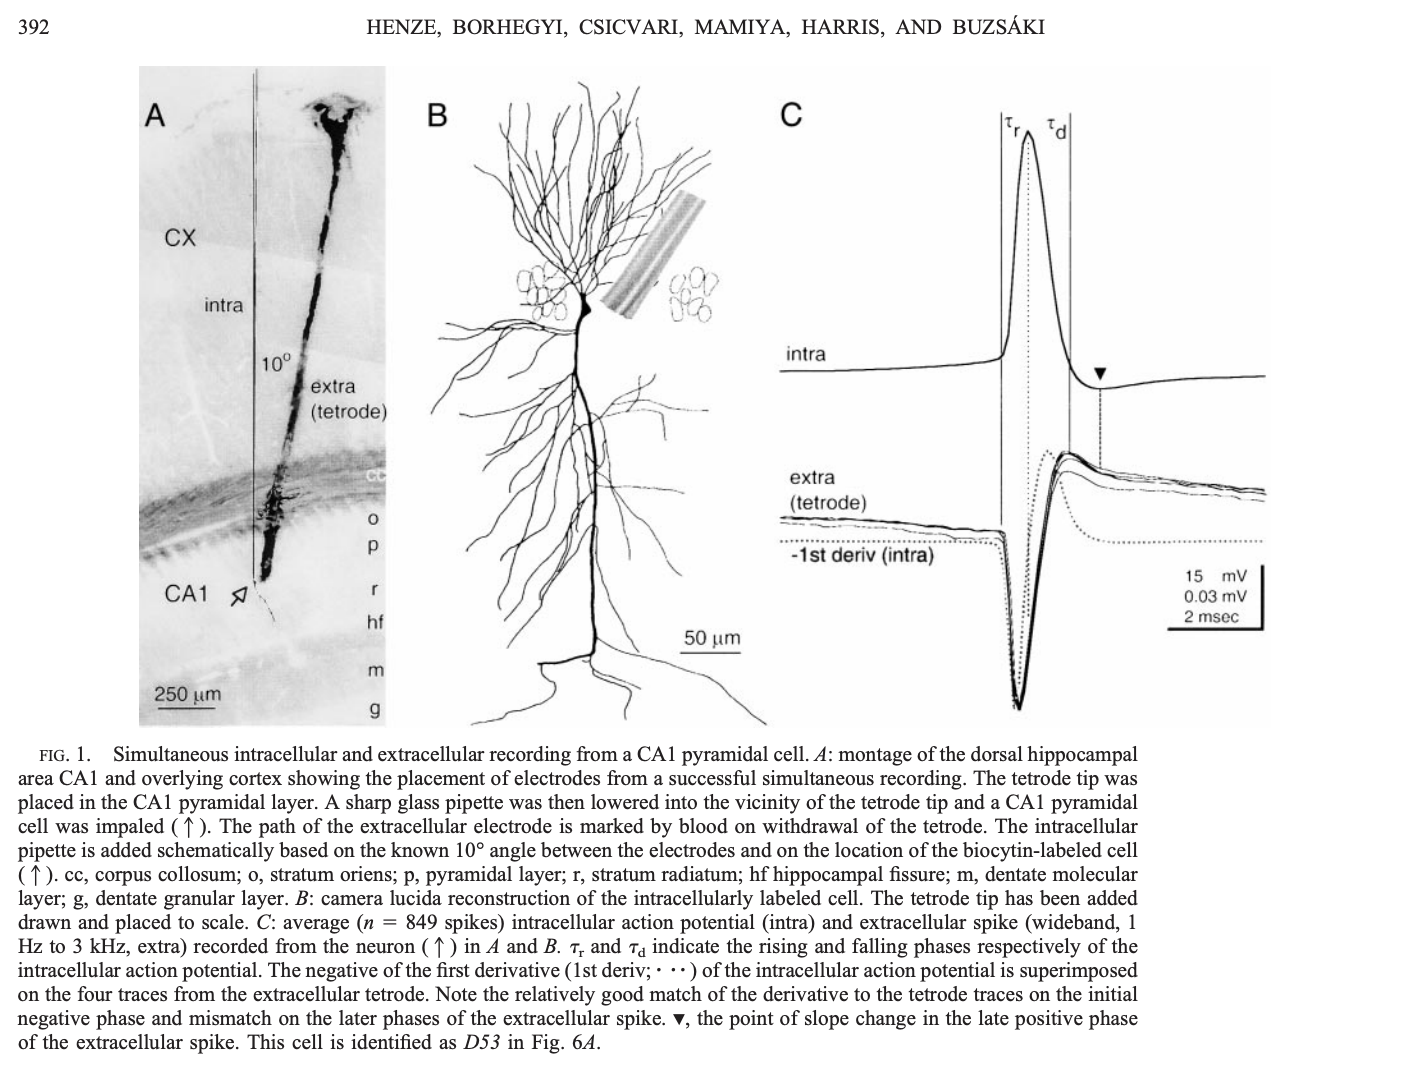

Comparing the work of Buzsaki et. al. with the above unimodal model of electrical potential, we can see that there is a direct similarity between our intracellular (i.e. action) potential and extracellular potential (which is measured at multiple distances). Because the findings are consistent with the work done by Buzsaki et. al., we can confirm that indeed the model described above is an accurate depiction of the intracellular and extracellular recording of a nerve cell.